#####  ライブラリのインポート

In [105]:
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm
from tqdm.notebook import trange
from time import time
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import random


import pyconll
import pyconll.tree
from pqgrams.tree import Node
from pqgrams.PQGram import Profile

from scripts.TreeKernel import tree, tree_kernels
from scripts import create_strings, trees, dist

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import japanize_matplotlib

import re
%matplotlib inline


In [106]:
CoNLL_EWT = pyconll.load_from_file("corpora/English/English-EWT.conllu")
num_EWT = len(CoNLL_EWT)

P = 2
Q = 2

## $pq$-gram distance

### 文長による依存性

In [99]:
def get_distances_list(
        data: list
    ):

    values = []

    for i, tree_i in enumerate(data):
        for tree_j in data[i+1:]:
            distance = dist.pqgram_distance(tree_i, tree_j)
            values.append(distance)
    
    return values

#### ノード数を揃える

In [107]:
lengths_each = [[]]
for _ in range(50):
    lengths_each.append([])

for sentence in tqdm(CoNLL_EWT):

    length = len(sentence)

    if length > 50:
        continue

    t_pq = trees.conllTree_to_pqTree_unlabeled(sentence.to_tree())
    pq_index = Profile(t_pq, P, Q)
    
    lengths_each[length].append(pq_index)
    
distances_each = [[]]
for _ in range(50):
    distances_each.append([])

for i in trange(51):
    pqgrams_list = lengths_each[i]
    if len(pqgrams_list) <= 0:
        continue
    distances = get_distances_list(pqgrams_list)
    distances_each[i].append(distances)

distances_each
    

  0%|          | 0/16621 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

[[],
 [[0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   

### 一般の木との比較

#### 完全二分木との比較

In [22]:
t = create_strings.create_complete_tree_TK_upos(5, [1,2,3,4,5])

In [23]:
x = t.printFormat()

In [24]:
x

'1(2(4,5),3)'

In [25]:
def parse_prolog_tree(prolog_str):
    def helper(s):
        if not s:
            return None, ""
        
        # Match the label
        match = re.match(r"(\w+)", s)
        if not match:
            raise ValueError("Invalid format")
        
        label = match.group(1)
        node = Node(label)
        
        rest = s[match.end():]
        if rest.startswith("("):
            # Parse children
            rest = rest[1:]  # Remove '('
            while not rest.startswith(")"):
                child, rest = helper(rest)
                node.addkid(child)
                if rest.startswith(","):
                    rest = rest[1:]  # Remove ','
            rest = rest[1:]  # Remove ')'
        
        return node, rest

    tree, remaining = helper(prolog_str)
    if remaining:
        raise ValueError(f"Unexpected characters in input: {remaining}")
    return tree


t = parse_prolog_tree(x)

In [26]:
t

In [27]:
pqindex = Profile(t, p=2, q=2)

In [28]:
for pqgram in pqindex:
    print(pqgram)

('*', '1', '*', '2')
('*', '1', '2', '3')
('*', '1', '3', '*')
('1', '2', '*', '4')
('1', '2', '4', '5')
('1', '2', '5', '*')
('1', '3', '*', '*')
('2', '4', '*', '*')
('2', '5', '*', '*')


In [61]:
P = 2
Q = 2

length_list = []
distance_list = []

for sentence in tqdm(CoNLL_EWT):

    pqtree_ewt = trees.conllTree_to_pqTree_unlabeled(sentence.to_tree())
    pqgrams_ewt = Profile(pqtree_ewt, p=P, q=Q)

    length = len(sentence)
    labels = ["_" for _ in range(length)]
    t_cmp = create_strings.create_complete_tree_TK_unlabel(length, labels)
    t_cmp_pq = parse_prolog_tree(t_cmp.printFormat())
    pqgrams_cmp = Profile(t_cmp_pq, P, Q)

    distance = dist.pqgram_distance(pqgrams_ewt, pqgrams_cmp)

    length_list.append(length)
    distance_list.append(distance)

  0%|          | 0/16621 [00:00<?, ?it/s]

Text(0, 0.5, '$pq$-gram distance')

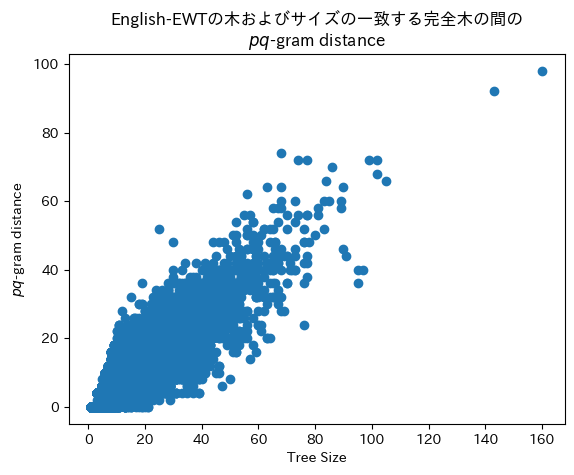

In [59]:
fig, ax = plt.subplots()

ax.scatter(length_list, distance_list)
ax.set_title("English-EWTの木およびサイズの一致する完全木の間の"+"\n"+r"$pq$-gram distance")
ax.set_xlabel("Tree Size")
ax.set_ylabel(r"$pq$-gram distance")

In [65]:
P = 2
Q = 2

distances = [[0]]
for i in range(50):
    distances.append([])

for sentence in tqdm(CoNLL_EWT):

    length = len(sentence)
    if length > 50:
        continue

    pqtree_ewt = trees.conllTree_to_pqTree_unlabeled(sentence.to_tree())
    pqgrams_ewt = Profile(pqtree_ewt, p=P, q=Q)

    
    labels = ["_" for _ in range(length)]
    t_cmp = create_strings.create_complete_tree_TK_unlabel(length, labels)
    t_cmp_pq = parse_prolog_tree(t_cmp.printFormat())
    pqgrams_cmp = Profile(t_cmp_pq, P, Q)

    distance = dist.pqgram_distance(pqgrams_ewt, pqgrams_cmp)

    distances[length].append(distance)

print(distances)

  0%|          | 0/16621 [00:00<?, ?it/s]

[[0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [66]:
distances_mean = [np.mean(np.array(d)) for d in distances]

In [67]:
distances_mean

[0.0,
 0.0,
 0.0,
 1.1623711340206186,
 2.508411214953271,
 3.1735537190082646,
 5.3,
 5.548192771084337,
 7.41965678627145,
 6.868217054263566,
 8.392914653784219,
 8.038034865293186,
 9.79672131147541,
 8.897163120567376,
 10.803603603603603,
 10.118918918918919,
 11.88411214953271,
 11.242152466367713,
 12.618101545253863,
 12.470066518847007,
 13.763097949886104,
 13.240997229916898,
 15.11731843575419,
 14.567639257294429,
 16.17737003058104,
 15.553903345724907,
 18.409448818897637,
 16.4,
 18.548672566371682,
 17.806763285024154,
 20.049382716049383,
 19.12849162011173,
 20.93243243243243,
 19.579710144927535,
 21.792,
 19.728155339805824,
 22.617021276595743,
 23.28846153846154,
 24.256410256410255,
 22.043478260869566,
 24.514285714285716,
 24.56338028169014,
 26.830188679245282,
 24.470588235294116,
 28.925925925925927,
 27.771428571428572,
 28.266666666666666,
 28.636363636363637,
 30.470588235294116,
 30.533333333333335,
 32.0]

[ 5 10 15 20 25 30 35 40 45 50]


Text(0, 0.5, 'Kernel Value')

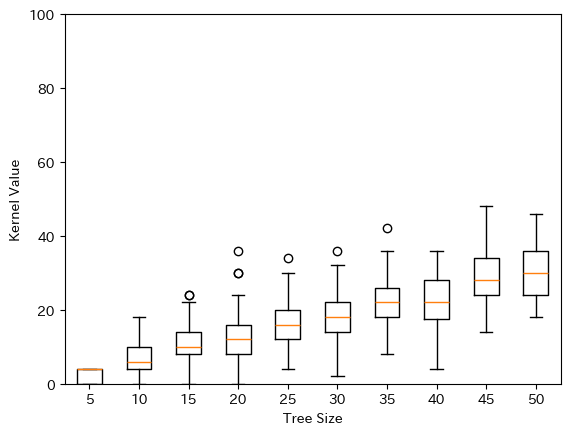

In [76]:
# 箱びげプロット
x = np.array([i*5 for i in range(1, 11)])
print(x)
Y = [distances[i*5-1] for i in range(1, 11)]
Y = tuple(Y)

fig, ax = plt.subplots()

bp = ax.boxplot(Y)

ax.set_ylim(0,100)
ax.set_xticklabels([i*5 for i in range(1,11)])
ax.set_xlabel("Tree Size")
ax.set_ylabel("Kernel Value")

Text(0, 0.5, 'Mean of $pq$-gram distance')

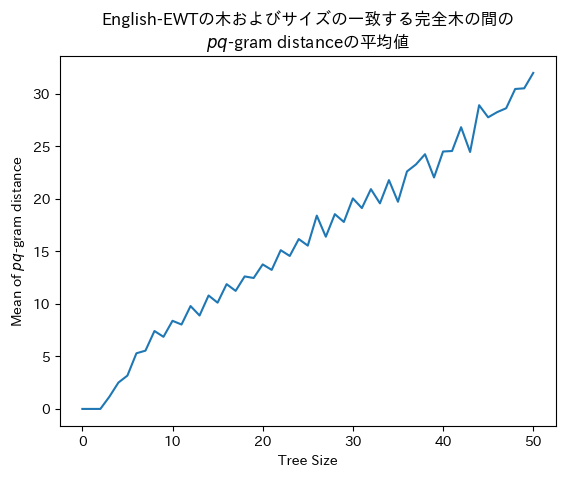

In [73]:
fig, ax = plt.subplots()

ax.plot(range(51), distances_mean)

ax.set_title("English-EWTの木およびサイズの一致する完全木の間の"+"\n"+r"$pq$-gram distanceの平均値")
ax.set_xlabel("Tree Size")
ax.set_ylabel(r"Mean of $pq$-gram distance")